In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files

import os, cv2, numpy as np, matplotlib.pyplot as plt, random, imgaug as ia
%matplotlib inline

from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imgaug.augmenters as iaa
import imgaug as ia
import random, time
import shutil
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow

from pprint import pprint

In [0]:
location = "/content/drive/Shared drives/SIH-COODLE/dataset_final"
a = open(location + '/train.jpg', 'w+')
a.close()
directories = ["ANTI_CLOCKWISE",
               "CLOCKWISE",
               "FORWARD",
               "BACKWARD",
               "RIGHT",
               "LEFT",
               "ROTATE",
               "START",
               "STOP",
               "REPEAT",
               "END_REPEAT",
               "IF",
               "ELSE",
               "TIMES"]

In [0]:
ia.seed(int(random.random()*1000))
# Defining a function to implement probability of applying an opearation
sometimes = lambda aug, prob: iaa.Sometimes(prob, aug)

seq = iaa.Sequential(
    [
        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1)), 0.3),

        # Apply affine transformations to some of the images
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-30, 30),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        ), 0.8),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        sometimes(iaa.SomeOf((0, 2),
            [
                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),


                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),
                          0.1),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)), 0.1)
            ],
            # do all of the above augmentations in random order
            random_order=True
        ), 0.3)
    ],
    # do all of the above augmentations in random order
    random_order=True
)


In [0]:
def augment(image_files, image_folder, annotation_folder, class_folder):
    print(image_files)
    image_class = class_folder.lower()
    index = -1
    for img in image_files:
        index = index + 1
        img = img.split('.')[0]
        image_name = os.path.join(image_folder, img + '.jpg')
        annot_name = os.path.join(annotation_folder, img + '.txt')
        print(image_name)
        image = cv2.imread(image_name)
        annotation = open(annot_name)
        
        image_output = os.path.join(root_output,aug_folder)
        annot_output = os.path.join(image_output, "annots")

        print(image_output)
        print(annot_output)

        values = annotation.readline().split()
        values = [float(x) for x in values]

        class_number = int(values[0])
        shape = image.shape
        height, width = float(shape[0]), float(shape[1])
        
        data = {
            'x1': ((2*values[1]-values[3])*width)/2,
            'y1': ((2*values[2]-values[4])*height)/2,
            'x2': ((2*values[1]+values[3])*width)/2,
            'y2': ((2*values[2]+values[4])*height)/2
        }
        print(shape)
        print(data)
        bbs = BoundingBoxesOnImage([
            BoundingBox(**data)
            ], shape=shape)

        for i in range(15):
            # 15 augmentations for 1 image
            image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
            output_image_path = os.path.join(image_output, image_class + "_" + str(index) + "_" + str(i) + '.jpg')
            output_annot_path = os.path.join(annot_output, image_class + "_" + str(index) + "_" + str(i) + '.txt')
            temp = open(output_image_path, 'w+')
            temp.close()
            if(not cv2.imwrite(output_image_path, image_aug)):
              print("Error in writing image : "+str(output_image_path))

            box = bbs_aug.bounding_boxes[0]
            outshape = image_aug.shape
            print(outshape, box)
            height, width = float(outshape[0]), float(outshape[1])
            x1 = box.x1
            x2 = box.x2 
            y1 = box.y1
            y2 = box.y2

            x1 = (x1+x2)/(2*width)
            y1 = (y1+y2)/(2*height)
            w = abs(x2-x1)/width
            h = abs(y2-y1)/height

            anout = open(output_annot_path, 'w+')
            anout.write(f'{class_number} {x1} {y1} {w} {h}')
            anout.close()

        annotation.close()

In [0]:
# run this for creating augmented images

aug_folder='aug_output1/'
root=location
root_output = "/content/drive/Shared drives/SIH-COODLE/"
# image_output = os.path.join(root_aug, 'images')
# annot_output = os.path.join(root_aug, 'ANNOTS')

input_folders = os.listdir(root)
print(input_folders)

['END_REPEAT', 'FORWARD', 'CLOCKWISE', 'ANTI_CLOCKWISE', 'ELSE', 'IF', 'LEFT', 'REPEAT', 'RIGHT', 'ROTATE', 'START', 'STOP', 'TIMES', 'BACKWARD', 'train.jpg']


In [0]:


# output_image_folder = os.path.join(root_aug, 'images')
# output_annotation_folder = os.path.join(root_aug, 'ANNOTS')

# For each class_folder in the training folder
for class_folder in input_folders:
    annotation_folder = os.path.join(root,class_folder, 'annots')
    image_folder  = os.path.join(root,class_folder)

    image_list = os.listdir(image_folder+"/")
    image_list.remove('annots')

    # print(image_folder)
    # print(annotation_folder)
    # print(image_list)

    augment(image_list, image_folder, annotation_folder, class_folder)     

['IMG_1369.jpg', 'IMG_1354.jpg', 'IMG_1403.jpg', 'IMG_1439.jpg', 'IMG_1365.jpg', 'MVIMG_20200311_212205.jpg', 'IMG_20200311_222525.jpg', 'IMG_20200311_224928.jpg', 'MVIMG_20200311_213201.jpg', 'IMG_20200311_225410.jpg', 'IMG_20200311_224519.jpg', 'IMG_20200311_222331.jpg', 'IMG_20200311_225030.jpg', 'IMG_20200311_225448.jpg', 'IMG_20200311_212639.jpg', 'IMG_20200311_222247.jpg', 'IMG_20200311_212641.jpg', 'IMG_20200311_225701.jpg', 'IMG_20200311_221834.jpg', 'IMG_20200311_213826.jpg', 'IMG_20200311_213439.jpg', 'IMG_20200311_225239.jpg', 'IMG_20200311_225631.jpg', 'IMG_20200311_225148.jpg', 'IMG_20200311_221646.jpg', 'MVIMG_20200311_212359.jpg', 'IMG_20200311_213951.jpg', 'MVIMG_20200311_212221.jpg', 'IMG_20200311_221751.jpg']
/content/drive/Shared drives/SIH-COODLE/dataset_final/END_REPEAT/IMG_1369.jpg
/content/drive/Shared drives/SIH-COODLE/aug_output1/
/content/drive/Shared drives/SIH-COODLE/aug_output1/annots
(3024, 3024, 3)
{'x1': 2047.999464, 'y1': 1091.000232, 'x2': 2715.99804, 

In [0]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2020-03-29 12:15:22--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   471KB/s    in 6m 14s  

2020-03-29 12:21:37 (648 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [0]:
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.17 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (3921/3921), done.
Checking out files: 100% (979/979), done.


In [0]:
cd darknet/

/content/drive/Shared drives/SIH-COODLE/darknet


In [0]:
# for testing for a image
!./darknet detector test  /yolo/custom_data/detector.data /yolo/custom_data/cfg/yolov3-custom.cfg /yolo/custom_data/backup/yolov3-custom_1000.weights /yolo/aug_output/left_17_11.jpg -thresh 0.01

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    8 res    5                 104 x 104 x 128   ->   104 x 104 x 128
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
   11 res    8                 104 x 

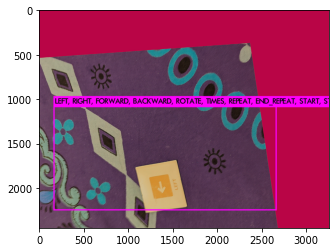

In [0]:
image = cv2.imread("predictions.jpg")
imshow(image)

In [0]:
!make

gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:947:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas

In [0]:


destination = '/content/drive/Shared drives/SIH-COODLE/aug_output/'
target = '/content/drive/Shared drives/SIH-COODLE/custom_data/images/'
destination_list = os.listdir(destination)
data_dir_list = os.listdir(target)
for fileName in destination_list:
   if not os.path.isdir(os.path.join(destination, fileName)):
       for prefix in data_dir_list:
           if fileName.startswith(prefix):
               shutil.copy(os.path.join(destination, fileName), os.path.join(target, prefix, fileName))

In [0]:

from sklearn.model_selection import train_test_split

def split_dataset(location):
	
	images = os.listdir(location)
	

	dummy = [None]*(len(images))

	images_train, images_test, dummy_train, dummy_test = train_test_split(images, dummy, test_size=0.25, shuffle=True)

	return images_train,images_test




In [0]:
img_train, img_test = split_dataset("/content/drive/Shared drives/SIH-COODLE/custom_data/images/backward")


In [0]:
MyFile=open('/content/drive/Shared drives/SIH-COODLE/custom_data/train.txt','a')
for element in img_train:
     MyFile.write(element)
     MyFile.write('\n')
MyFile.close()


In [0]:
MyFile=open('/content/drive/Shared drives/SIH-COODLE/custom_data/test.txt','a')
for element in img_test:
     MyFile.write(element)
     MyFile.write('\n')
MyFile.close()


In [0]:
#train and test created

In [0]:
ls

custom.names  detector.data  images/  test.txt  train.gdoc  train.txt


In [0]:
cd custom_data/


/content/drive/Shared drives/SIH-COODLE/custom_data


In [0]:
source = '/content/drive/Shared drives/SIH-COODLE/aug_output/annots/'
dest1 = '/content/drive/Shared drives/SIH-COODLE/aug_output/'

files = os.listdir(source)

for f in files:
    shutil.move(source+f, dest1)

In [0]:
ls

backup/    include/       LICENSE.gen   Makefile         results/
cfg/       libdarknet.a   LICENSE.gpl   obj/             scripts/
darknet    libdarknet.so  LICENSE.meta  predictions.jpg  src/
data/      LICENSE        LICENSE.mit   python/          yolov3.weights
examples/  LICENSE.fuck   LICENSE.v1    README.md


In [0]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-04-01 09:13:53--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M   126KB/s    in 13m 2s  

2020-04-01 09:26:57 (203 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [0]:
!ln -s "/content/drive/Shared drives/SIH-COODLE/" /yolo


ln: failed to create symbolic link '/yolo/SIH-COODLE': Operation not supported


In [0]:
cd /yolo

/content/drive/Shared drives/SIH-COODLE


In [0]:
cd /yolo/darknet/

/content/drive/Shared drives/SIH-COODLE/darknet


In [0]:
!chmod u+x darknet

In [0]:
!./darknet detector train  /content/drive/Shared\ drives/SIH-COODLE/custom_data/detector.data /content/drive/Shared\ drives/SIH-COODLE/custom_data/cfg/yolov3-custom.cfg /yolo/custom_data/backup/yolov3-custom_1000.weights -dont_show

yolov3-custom
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    8 res    5                 104 x 104 x 128   ->   104 x 104 x 128
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
   11 res    8         

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [0]:
!cat /yolo/custom_data/train.txt

In [0]:
#This cell can be commented once you checked the current CUDA version
# CUDA: Let's check that Nvidia CUDA is already pre-installed and which version is it. In some time from now maybe you 
!/usr/local/cuda/bin/nvcc --version

In [0]:
# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders
!tar -xzvf /yolo/custom_data/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

In [0]:
cd /yolo/custom_data/

In [0]:
cd ..

In [0]:
ls

In [0]:
!cat detector.data